# Metal-Archives reviews - Part 2: Review score prediction

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

In [2]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# Dataset

In [3]:
df = pd.read_csv('E:/Projects/metallyrics/data/new/reviews.csv')

In [4]:
df['review_title'], df['review_score'] = df['review_title'].str.extract('(.*) - (\d+)%').values.T
df['review_score'] = df['review_score'].astype(int)

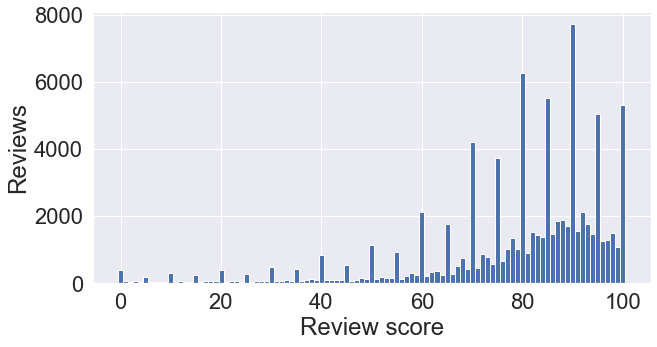

In [5]:
hist = df['review_score'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(hist.index, hist.values, width=1)
plt.xlabel("Review score")
plt.ylabel("Reviews")
plt.show()

# Review score prediction using Glove word embeddings

### Data preprocessing

In [6]:
X = df['review_content']
y = df['review_score'] / 100

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Sample weights

In [8]:
train_hist = y_train.value_counts().sort_index()
intervals = pd.cut(train_hist.index, np.linspace(y.min(), y.max(), 11), include_lowest=True).categories
bin_counts = np.zeros(len(intervals))
for i, interval in enumerate(intervals):
    for j in train_hist.index:
        if j in interval:
            bin_counts[i] += train_hist[j]
sample_bins = np.zeros(len(y_train), dtype=int)
for i, y in enumerate(y_train):
    for j, interval in enumerate(intervals):
        if y in interval:
            sample_bins[i] = j
            break
sample_weights = 1.0 / bin_counts[sample_bins]
sample_weights /= sample_weights.sum()

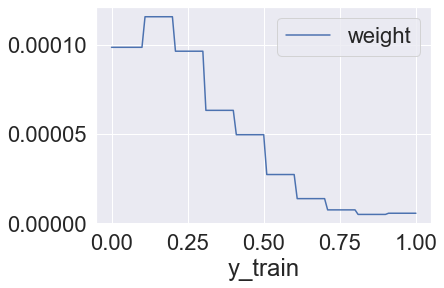

In [9]:
pd.DataFrame(np.column_stack([y_train, sample_bins, sample_weights]), columns=["y_train", "bin", "weight"]).convert_dtypes().sort_values('y_train').plot('y_train', 'weight')
plt.show()

### Convert text to padded sequences of tokens

In [10]:
tokenizer = keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r\'')
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.index_word) + 1
print(f"vocabulary size: {vocab_size}")

vocabulary size: 256786


In [11]:
def texts_to_padded(texts, maxlen=None):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = keras.preprocessing.sequence.pad_sequences(sequences, padding='post', maxlen=maxlen)
    return padded

In [12]:
padded_train = texts_to_padded(X_train)
padded_test = texts_to_padded(X_test)

In [13]:
pd.DataFrame(np.sum(padded_train > 0, axis=1), columns={"Sequence length"}).describe()

,Sequence length
count,69160.000000
mean,601.691281
std,281.243588
min,91.000000
25%,415.000000
50%,549.500000
75%,724.000000
max,5769.000000


In [14]:
print(padded_train.shape, y_train.shape, padded_test.shape, y_test.shape)

(69160, 5769) (69160,) (17290, 6849) (17290,)


### Benchmark model

This benchmark model "predicts" scores by sampling from the distribution of scores in the training data, so it represents the outcome of informed random guessing.

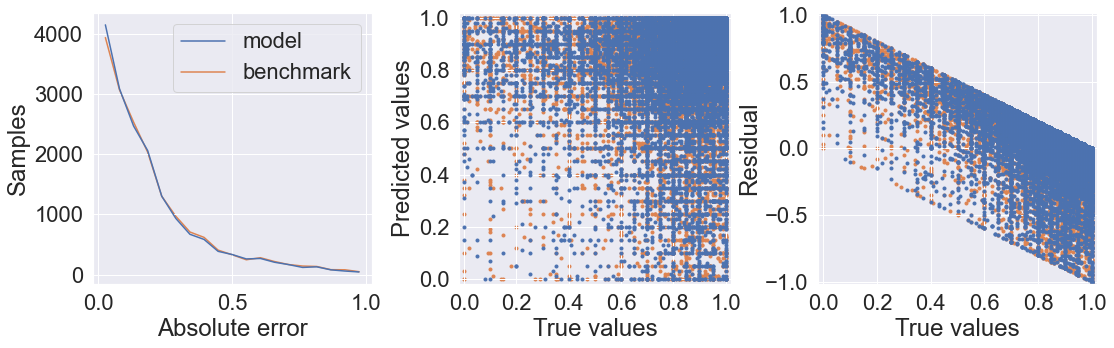

In [16]:
train_pdf = y_train.value_counts().sort_index()
train_cdf = train_pdf.cumsum() / train_pdf.sum()


def benchmark_predict(n_samples):
    r = np.random.rand(n_samples)
    pred_idx = np.argmax((train_cdf.values[:, None] - r) > 0, axis=0)
    pred = train_cdf.index[pred_idx]
    return pred

def evaluate_prediction(pred, true, benchmark=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    fig.subplots_adjust(wspace=0.3)
    bins = np.linspace(0, 1, 20)
    hist, bins = np.histogram(np.abs(pred - true), bins=bins)
    bin_centers = bins[:-1] + np.diff(bins)[0] / 2
    ax1.plot(bin_centers, hist, label="model", zorder=1)
    ax2.plot(true, pred, '.', zorder=1)
    ax3.plot(true, pred - true, '.', zorder=1)
    if benchmark:
        y_bench = benchmark_predict(len(true))
        hist_bm, _ = np.histogram(np.abs(y_bench - true), bins=bins)
        ax1.plot(bin_centers, hist_bm, label="benchmark", zorder=0)
        ax2.plot(true, y_bench, '.', zorder=0)
        ax3.plot(true, y_bench - true, '.', zorder=0)
    ax1.set_xlabel("Absolute error")
    ax1.set_ylabel("Samples")
    ax1.legend()
    ax2.set_xlabel("True values")
    ax2.set_ylabel("Predicted values")
    ax2.set_xlim(-0.02, 1.02)
    ax2.set_ylim(-0.02, 1.02)
    ax2.set_xticks(np.linspace(0, 1, 6))
    ax2.set_yticks(np.linspace(0, 1, 6))
    ax2.set_aspect('equal')
    ax3.set_xlabel("True values")
    ax3.set_ylabel("Residual")
    ax3.set_xlim(-0.02, 1.02)
    ax3.set_ylim(-1.02, 1.02)
    ax3.set_xticks(np.linspace(0, 1, 6))
    ax3.set_yticks(np.linspace(-1, 1, 5))
    plt.show()

evaluate_prediction(benchmark_predict(len(y_test)), y_test, benchmark=True)

### Load word vectors and create an embedding layer

Adapted from [a Keras tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/).

Here I create a word embedding layer in order to convert each token in each sequence into a word vector.
I use a pre-trained word embedding, the 6-billion-token, 100-dimensional
Wikipedia+Gigaword 5 word embedding from [GloVe](https://nlp.stanford.edu/projects/glove/).
This transforms each token into a 100-dimensional vector whose location in the word vector space represents
its association to nearby word vectors.
The full dataset will therefore be represented as a matrix of shape (number of samples, sequence length, 100).

In [17]:
path_to_glove_file = "E:/Projects/metallyrics/data/glove.6B.100d.txt"

embedding_vectors = {}
with open(path_to_glove_file, encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_vectors[word] = coefs
print(len(embedding_vectors))
print(len(list(embedding_vectors.values())[0]))

400001
100


In [18]:
embedding_dim = len(list(embedding_vectors.values())[0])
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) > 0:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
            continue
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 84032 words (172753 misses)


As an example, we can see look at the 10 nearest words to "fire", based on cosine distance.

In [19]:
vector = embedding_vectors['fire']
cos_dist = np.dot(embedding_matrix, vector) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(vector))
cos_dist = np.nan_to_num(cos_dist, 0)
print([tokenizer.index_word.get(i, 0) for i in cos_dist.argsort()][:-11:-1])

['fire', 'fires', 'fired', 'firing', 'attack', 'explosion', 'blast', 'blaze', 'police', 'ground']


C:\Users\philn\AppData\Local\Temp\ipykernel_11568\952163309.py:2: RuntimeWarning: invalid value encountered in true_divide
  cos_dist = np.dot(embedding_matrix, vector) / (np.linalg.norm(embedding_matrix, axis=1) * np.linalg.norm(vector))


In [20]:
embedding_layer = layers.Embedding(
    vocab_size,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

### Convolutional Neural Network

After a little manual hyperparameter tuning (tweaking the number of filters, dense layer size, learning rate, and regularization methods),
I found that this model was unable to learn at all using mean squared error (MSE) for the loss function.
Mean absolute error (MAE) worked instantly when implemented.
This is probably because MSE does well at punishing outliers, but there the review score range is bounded,
so there are no huge outliers in the data.

I also tested it with and without sample weighting since the test samples are heavily distributed in favor of high-scoring reviews.
I found that with sample weighting, the model was less likely to overestimate the scores of negative reviews.
However, the residual plots show that there is still a decent amount of bias towards overestimating scores,
although it does perform much better than the random sampling benchmark.

Any further tuning should probably be done with cross-validation just to robust,
but I'm pretty happy with the model as is so I'm leaving it as is.

Also, I tried training a recurrent neural network on the data and it miserably overfit,
and tuning took too long because of the very slow training time. Oh well, I'm happy with the ConvNet!

In [21]:
cnn_model = Sequential()
cnn_model.add(embedding_layer)
cnn_model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.GlobalMaxPooling1D())
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(1, activation='linear'))
opt = keras.optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         25678600  
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [22]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [23]:
cnn_history = cnn_model.fit(
    padded_train[::10],
    y_train[::10],
    batch_size=32,
    callbacks=[early_stopping],
    epochs=64,
    sample_weight=sample_weights,
    validation_split=0.2,
    verbose=1
)

Epoch 1/64
173/173 [==============================] - 88s 500ms/step - loss: 5.8694e-05 - mae: 4.1086 - val_loss: 1.4992e-05 - val_mae: 1.0833
Epoch 2/64
173/173 [==============================] - 93s 539ms/step - loss: 2.0165e-05 - mae: 1.3171 - val_loss: 1.2310e-05 - val_mae: 0.8717
Epoch 3/64
173/173 [==============================] - 94s 544ms/step - loss: 1.6722e-05 - mae: 1.1126 - val_loss: 4.7313e-06 - val_mae: 0.3427
Epoch 4/64
173/173 [==============================] - 91s 527ms/step - loss: 8.8949e-06 - mae: 0.6018 - val_loss: 4.9187e-06 - val_mae: 0.3581
Epoch 5/64
173/173 [==============================] - 90s 523ms/step - loss: 8.4884e-06 - mae: 0.5732 - val_loss: 5.2625e-06 - val_mae: 0.3796
Epoch 6/64
173/173 [==============================] - 90s 522ms/step - loss: 5.8895e-06 - mae: 0.3963 - val_loss: 4.2899e-06 - val_mae: 0.2966
Epoch 7/64
173/173 [==============================] - 90s 523ms/step - loss: 5.2813e-06 - mae: 0.3673 - val_loss: 2.7561e-06 - val_mae: 0.1980

In [24]:
train_metrics = cnn_model.evaluate(padded_train, y_train, verbose=0)
test_metrics = cnn_model.evaluate(padded_test, y_test, verbose=0)
train_metrics = {cnn_model.metrics_names[i]: value for i, value in enumerate(train_metrics)}
test_metrics = {cnn_model.metrics_names[i]: value for i, value in enumerate(test_metrics)}

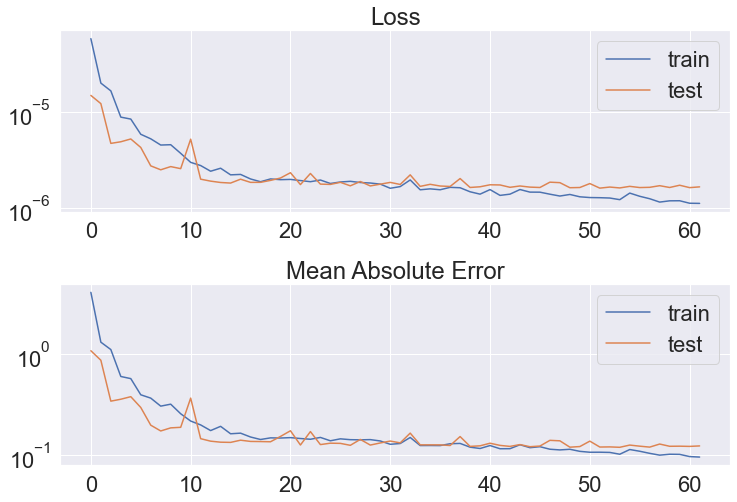

Train loss: 0.12
Test  loss: 0.12
Train mae: 0.12
Test  mae: 0.12


In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
ax1.set_title('Loss')
ax1.plot(cnn_history.history['loss'], label='train')
ax1.plot(cnn_history.history['val_loss'], label='test')
ax1.set_yscale('log')
ax1.legend()
ax2.set_title('Mean Absolute Error')
ax2.plot(cnn_history.history['mae'], label='train')
ax2.plot(cnn_history.history['val_mae'], label='test')
ax2.set_yscale('log')
ax2.legend()
plt.show()
for metric in cnn_model.metrics_names:
    print(f"Train {metric}: {train_metrics[metric]:.2f}")
    print(f"Test  {metric}: {test_metrics[metric]:.2f}")

In [26]:
y_pred = cnn_model.predict(padded_test)[:, 0]
y_pred = np.maximum(0, np.minimum(1, y_pred))

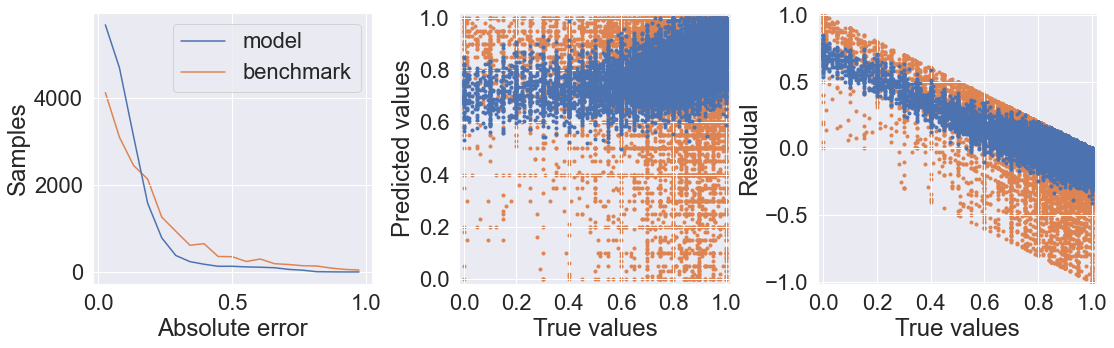

In [27]:
evaluate_prediction(y_pred, y_test, benchmark=True)

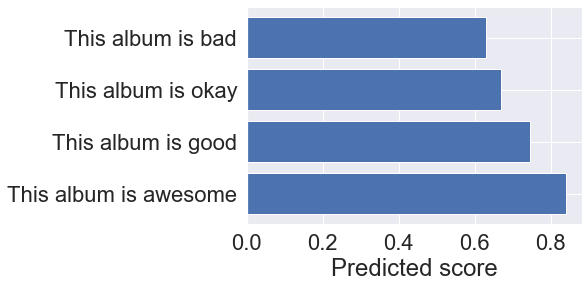

In [28]:
texts = ["This album is bad", "This album is okay", "This album is good", "This album is awesome"]
pred = cnn_model.predict(texts_to_padded(texts, maxlen=padded_train.shape[0]))[:, 0]
plt.barh(range(len(pred)), pred[::-1])
plt.yticks(range(len(pred)), texts[::-1])
plt.xlabel("Predicted score")
plt.show()

### LSTM

In [29]:
lstm_model = Sequential()
lstm_model.add(embedding_layer)
lstm_model.add(layers.SpatialDropout1D(0.2))
lstm_model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
lstm_model.add(layers.Dropout(0.2))
lstm_model.add(layers.BatchNormalization())
lstm_model.add(layers.Dense(1, activation='linear'))
opt = keras.optimizers.Adam(learning_rate=0.01)
lstm_model.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mae'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         25678600  
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 100)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                      

In [30]:
lstm_history = lstm_model.fit(
    padded_train[::10],
    y_train[::10],
    batch_size=32,
    callbacks=[early_stopping],
    epochs=64,
    sample_weight=sample_weights,
    validation_split=0.2,
    verbose=1
)

Epoch 1/64
173/173 [==============================] - 1176s 7s/step - loss: 5.4464e-06 - mae: 0.3862 - val_loss: 2.1095e-06 - val_mae: 0.1524
Epoch 2/64
173/173 [==============================] - 1220s 7s/step - loss: 3.0194e-06 - mae: 0.2050 - val_loss: 2.2214e-06 - val_mae: 0.1577
Epoch 3/64
110/173 [==================>...........] - ETA: 7:27 - loss: 2.7089e-06 - mae: 0.1912

KeyboardInterrupt: 

In [ ]:
train_metrics = lstm_model.evaluate(padded_train, y_train, verbose=0)
test_metrics = lstm_model.evaluate(padded_test, y_test, verbose=0)
train_metrics = {lstm_model.metrics_names[i]: value for i, value in enumerate(train_metrics)}
test_metrics = {lstm_model.metrics_names[i]: value for i, value in enumerate(test_metrics)}

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
ax1.set_title('Loss')
ax1.plot(lstm_history.history['loss'], label='train')
ax1.plot(lstm_history.history['val_loss'], label='test')
ax1.set_yscale('log')
ax1.legend()
ax2.set_title('Mean Absolute Error')
ax2.plot(lstm_history.history['mae'], label='train')
ax2.plot(lstm_history.history['val_mae'], label='test')
ax2.set_yscale('log')
ax2.legend()
plt.show()
for metric in lstm_model.metrics_names:
    print(f"Train {metric}: {train_metrics[metric]:.2f}")
    print(f"Test  {metric}: {test_metrics[metric]:.2f}")

In [ ]:
y_pred = lstm_model.predict(padded_test)[:, 0]
y_pred = np.maximum(0, np.minimum(1, y_pred))

In [ ]:
evaluate_prediction(y_pred, y_test, benchmark=True)

In [ ]:
texts = ["This album is bad", "This album is okay", "This album is good", "This album is awesome"]
pred = lstm_model.predict(texts_to_padded(texts, maxlen=padded_train.shape[0]))[:, 0]
plt.barh(range(len(pred)), pred[::-1])
plt.yticks(range(len(pred)), texts[::-1])
plt.xlabel("Predicted score")
plt.show()